In [1]:
!test ! -f "master.zip" && wget "https://github.com/karoldvl/ESC-50/archive/master.zip"

In [2]:
!unzip -qq master.zip

replace ESC-50-master/.circleci/config.yml? [y]es, [n]o, [A]ll, [N]one, [r]ename:^C


In [1]:
%cd ESC-50-master

/media/daniel/Daniel_Files/Google Drive/Master Data Analytics/Third Semester/Project/studentproject/notebooks/CNN-AudioImages-Pytorch/ESC-50-master


In [2]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import os
import IPython.display as ipd

In [3]:
df = pd.read_csv('meta/esc50.csv')

In [4]:
df.head()

filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

### Test only two categories.

In [5]:
df.category.unique()
classesToSelect = ['dog','cat']
numCat = len(classesToSelect)
#Select only those who are in this classes to test
dfTest = df[df['category'].isin(classesToSelect)]
dfTest.reset_index()
df=dfTest
df.head()

filename  fold  target category  esc10  src_file take
0    1-100032-A-0.wav     1       0      dog   True    100032    A
14   1-110389-A-0.wav     1       0      dog   True    110389    A
157   1-30226-A-0.wav     1       0      dog   True     30226    A
158   1-30344-A-0.wav     1       0      dog   True     30344    A
170   1-32318-A-0.wav     1       0      dog   True     32318    A

In [6]:
train = df[df['fold']!=5]
valid = df[df['fold']==5]

In [7]:
wav, sr = librosa.load('audio/1-100032-A-0.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')
ipd.Audio(data=wav, rate=sr)

Sampling rate of the audio is 44100 and length of the audio is 5.0 seconds


In [8]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [9]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [10]:
class ESC50Data(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    print(self.categories)
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    print(self.c2i)
    print(self.i2c)
    print(len(df))
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = os.path.join(base,row[in_col])
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
      self.labels.append(self.c2i[row['category']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [11]:
train = df[df['fold']!=5]
valid = df[df['fold']==5]
train_data = ESC50Data('audio', train, 'filename', 'category')


['cat', 'dog']
{'cat': 0, 'dog': 1}
{0: 'cat', 1: 'dog'}
64


In [12]:
train_data.data[6].shape

(1, 128, 431)

In [13]:
class ESC50Model(nn.Module):
  def __init__(self, input_shape, batch_size=16, num_cats=50):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(128)
    self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.bn7 = nn.BatchNorm2d(256)
    self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    self.bn8 = nn.BatchNorm2d(256)
    self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),500)
    self.dropout = nn.Dropout(0.5)
    self.dense2 = nn.Linear(500, num_cats)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = F.max_pool2d(x, kernel_size=2) 
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = self.conv4(x)
    x = F.relu(self.bn4(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv5(x)
    x = F.relu(self.bn5(x))
    x = self.conv6(x)
    x = F.relu(self.bn6(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv7(x)
    x = F.relu(self.bn7(x))
    x = self.conv8(x)
    x = F.relu(self.bn8(x))
    x = x.view(x.size(0),-1)
    x = F.relu(self.dense1(x))
    x = self.dropout(x)
    x = self.dense2(x)
    return x


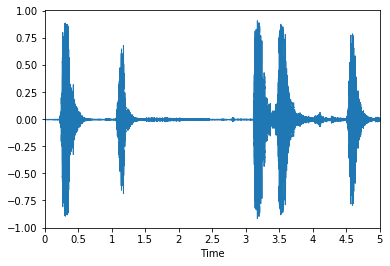

In [14]:
filename = valid[valid['category']=='dog'].iloc[0]['filename']
wav, sr = librosa.load('audio/'+filename, sr=None)
librosa.display.waveplot(wav, sr)

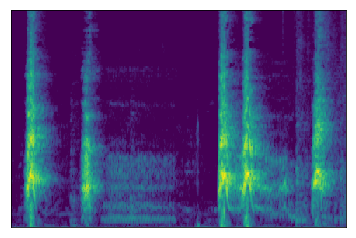

In [15]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db('audio/'+filename, sr)) , cmap='viridis')

In [16]:
train_data = ESC50Data('audio', train, 'filename', 'category')

['cat', 'dog']
{'cat': 0, 'dog': 1}
{0: 'cat', 1: 'dog'}
64


In [17]:
valid_data = ESC50Data('audio', valid, 'filename', 'category')

['cat', 'dog']
{'cat': 0, 'dog': 1}
{0: 'cat', 1: 'dog'}
16


In [18]:
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=8, shuffle=True)

In [19]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

#For testing force to use cpu until there is a cuda with enough memory
device=torch.device('cpu')
print(device)


cpu


In [20]:
model = ESC50Model(input_shape=(1,128,431), batch_size=16, num_cats=numCat).to(device)

In [21]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [22]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 5
train_losses = []
valid_losses = []

In [23]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    ##Test
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [24]:
def lr_decay(optimizer, epoch):
  if epoch%20==0:
    new_lr = learning_rate / (10**(epoch//20))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

Epoch - 1 Train-Loss : 0.6764585003256798
Epoch - 1 Valid-Loss : 0.6993009150028229 Valid-Accuracy : 0.5
Epoch - 2 Train-Loss : 0.22531145345419645
Epoch - 2 Valid-Loss : 0.719591349363327 Valid-Accuracy : 0.5
Epoch - 3 Train-Loss : 0.07942216144874692
Epoch - 3 Valid-Loss : 0.8715314269065857 Valid-Accuracy : 0.5
Epoch - 4 Train-Loss : 0.033950855024158955
Epoch - 4 Valid-Loss : 0.9630123376846313 Valid-Accuracy : 0.5
Epoch - 5 Train-Loss : 0.015836423495784402
Epoch - 5 Valid-Loss : 0.8049030601978302 Valid-Accuracy : 0.5



(40,)
[[0.665052056312561, 0.7269394993782043, 0.7450323700904846, 0.5215762257575989, 1.1076722145080566, 0.7003602981567383, 0.35983550548553467, 0.5851998329162598], [0.3556814193725586, 0.3412041664123535, 0.35416436195373535, 0.05733760446310043, 0.10739768296480179, 0.326632022857666, 0.17140138149261475, 0.08867298811674118], [0.17884321510791779, 0.15502819418907166, 0.03975173085927963, 0.10645703971385956, 0.04008398950099945, 0.012742076069116592, 0.05237053334712982, 0.05010051280260086], [0.011293232440948486, 0.005632258951663971, 0.06006345525383949, 0.014656491577625275, 0.09300089627504349, 0.044139306992292404, 0.03008187562227249, 0.012739323079586029], [0.007409490644931793, 0.004402272403240204, 0.016588373109698296, 0.013096004724502563, 0.007014840841293335, 0.03903459757566452, 0.02825818583369255, 0.010887622833251953]]


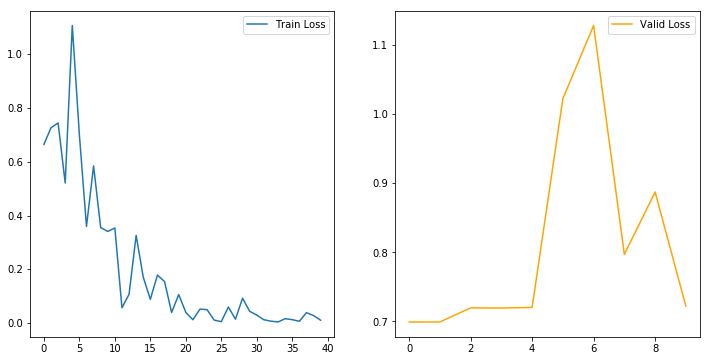

In [28]:
tl = np.asarray(train_losses).ravel()
print(tl.shape)
print(train_losses)
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [24]:
from torchvision.models import resnet34
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512,50)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/daniel/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:08<00:00, 10798901.43it/s]


In [25]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

Epoch - 1 Train-Loss : 2.476052018404007
Epoch - 1 Valid-Loss : 2.0681404066085816 Valid-Accuracy : 0.48
Epoch - 2 Train-Loss : 1.1600522780418396
Epoch - 2 Valid-Loss : 1.4278415775299071 Valid-Accuracy : 0.59
Epoch - 3 Train-Loss : 0.6945588180422783
Epoch - 3 Valid-Loss : 1.5378319072723388 Valid-Accuracy : 0.5975
Epoch - 4 Train-Loss : 0.5387453155219555
Epoch - 4 Valid-Loss : 1.5838733959197997 Valid-Accuracy : 0.595
Epoch - 5 Train-Loss : 0.42700489073991776
Epoch - 5 Valid-Loss : 1.424224603176117 Valid-Accuracy : 0.63
Epoch - 6 Train-Loss : 0.2938673056662083
Epoch - 6 Valid-Loss : 1.5562228786945342 Valid-Accuracy : 0.6375
Epoch - 7 Train-Loss : 0.21742349177598952
Epoch - 7 Valid-Loss : 1.0553581929206848 Valid-Accuracy : 0.7075
Epoch - 8 Train-Loss : 0.19196390807628633
Epoch - 8 Valid-Loss : 1.2534329986572266 Valid-Accuracy : 0.6475
Epoch - 9 Train-Loss : 0.20664175152778624
Epoch - 9 Valid-Loss : 1.3473841810226441 Valid-Accuracy : 0.6775
Changed learning rate to 2e-05
Ep

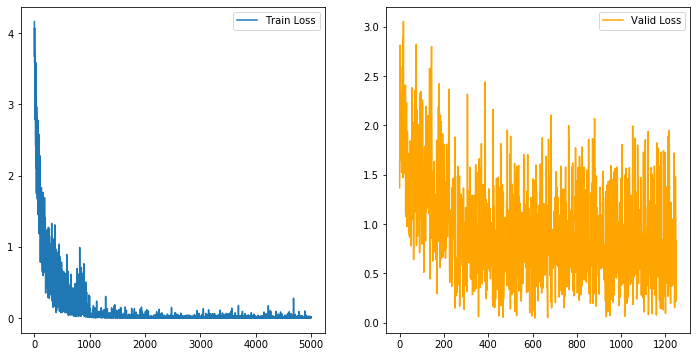

In [26]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [28]:
with open('esc50resnet.pth','wb') as f:
  torch.save(resnet_model, f)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist

In [0]:
import pickle
with open('indtocat.pkl','wb') as f:
  pickle.dump(train_data.i2c, f)

In [32]:
from google.colab import drive
!mkdir gdrive
drive.mount('gdrive')
!cp esc50resnet.pth gdrive/My\ Drive/
!cp indtocat.pkl gdrive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
import IPython
with open('indtocat.pkl','rb') as f:
  indtocat = pickle.load(f)
filename='/content/ESC-50-master/audio/1-116765-A-41.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

In [19]:
!wget 'http://soundbible.com/grab.php?id=2215&type=wav' -O "dog.wav"
filename='dog.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

Output hidden; open in https://colab.research.google.com to view.

In [20]:
!wget "http://soundbible.com/grab.php?id=1954&type=wav" -O "cat.wav"
filename='cat.wav'
spec=spec_to_image(get_melspectrogram_db(filename))
spec_t=torch.tensor(spec).to(device, dtype=torch.float32)
pr=resnet_model.forward(spec_t.reshape(1,1,*spec_t.shape))
ind = pr.argmax(dim=1).cpu().detach().numpy().ravel()[0]
print(indtocat[ind])
IPython.display.display(IPython.display.Audio(filename=filename))

cat
